# Synthetic Time Series Datasets Description

## Dataset Structure
- **Total samples**: 1000 points per dataset
- **Training set**: First 400 points
- **Test set**: Remaining 600 points

## Data Generation Process
1. Base Signal:
   - Sine wave with period ≈ 62.8 units (0.1 * t)
   - Amplitude: 1 unit
   - Time range: 0 to 100

2. Noise Component:
   - Gaussian noise
   - Mean: 0
   - Standard deviation: 0.1

3. Anomalies:
   - Located at indices: [450, 550, 650, 750]
   - Magnitude: +2 units above normal signal
   - All anomalies in test set

## Datasets Variants
1. Dataset1:
   - Original generated signal
   - Normal range: approximately [-1.1, 1.1]
   - Anomaly range: approximately [0.9, 3.1]

2. Dataset2:
   - Scaled version (1.5x) of Dataset1
   - Normal range: approximately [-1.65, 1.65]
   - Anomaly range: approximately [1.35, 4.65]

## Labels
- Binary classification: 0 (normal) or 1 (anomaly)
- Anomaly ratio in test set: ~0.67% (4 anomalies in 600 points)

In [36]:
import numpy as np
from sklearn.preprocessing import StandardScaler
from sklearn.ensemble import IsolationForest
from sklearn.svm import OneClassSVM
from sklearn.neighbors import LocalOutlierFactor
from sklearn.metrics import accuracy_score, f1_score, roc_auc_score, recall_score, precision_score
import pandas as pd 

In [47]:


class TimeSeriesAnomalyDetector:
    def __init__(self):
        self.algorithms = {
            'isolation_forest': IsolationForest(random_state=42),
            'one_class_svm': OneClassSVM(kernel='rbf', nu=0.1),
            'local_outlier_factor': LocalOutlierFactor(contamination=0.1, novelty=True)
        }
        self.scaler = StandardScaler()
        
    def prepare_features(self, data):
        features = []
        for i in range(len(data)-2):
            window = data[i:i+3]
            features.append([
                np.mean(window),
                np.std(window),
                np.max(window) - np.min(window),
                np.gradient(window).mean()
            ])
        return np.array(features)
    
    def detect_anomalies(self, train_data, test_data, true_labels):
        train_features = self.prepare_features(train_data)
        test_features = self.prepare_features(test_data)
        true_labels = true_labels[:len(test_features)]  # Adjust labels length
        
        train_features_scaled = self.scaler.fit_transform(train_features)
        test_features_scaled = self.scaler.transform(test_features)
        
        results = {}
        for name, algorithm in self.algorithms.items():
            algorithm.fit(train_features_scaled)
            predictions = algorithm.predict(test_features_scaled)
            
            predictions_binary = [1 if x == 1 else 0 for x in predictions]
            
            metrics = {
                'accuracy': accuracy_score(true_labels, predictions_binary),
                'f1': f1_score(true_labels, predictions_binary),
                'precision': precision_score(true_labels, predictions_binary),
                'recall': recall_score(true_labels, predictions_binary),
                'auc': roc_auc_score(true_labels, predictions_binary)
            }
            results[name] = metrics
            
        return results

def evaluate_datasets(datasets):
    detector = TimeSeriesAnomalyDetector()
    all_results = {}
    
    for dataset_name, (train_data, test_data, true_labels) in datasets.items():
        results = detector.detect_anomalies(train_data, test_data, true_labels)
        all_results[dataset_name] = results
    
    return all_results

def generate_example_data():
    np.random.seed(42)
    t = np.linspace(0, 100, 1000)
    #print(t)
    normal_data = np.sin(0.1 * t) + np.random.normal(0, 0.1, 1000)
    
    # Generate anomalies
    anomaly_indices = [450, 550, 650, 750]
    test_data = normal_data.copy()
    for idx in anomaly_indices:
        test_data[idx] += 2
    
    # Create splits
    train_data = normal_data[:400]
    test_data = test_data[400:]
    
    # Create labels for test set
    test_labels = np.zeros(len(test_data))
    for idx in anomaly_indices:
        if idx >= 400:  # Only for test set indices
            test_labels[idx-400] = 1
            
    return train_data, test_data, test_labels
 

 

In [80]:
train_data, test_data, labels = generate_example_data()
  
datasets = {
    'dataset1': (train_data, test_data, labels),
    'dataset2': (train_data * 1.5, test_data * 1.5, labels)
}

test_data[:40]

array([-0.9188563793, -0.8258255547, -0.7717613797, -0.773908005 ,
       -0.8298549104, -0.7287270274, -0.903858462 , -0.8173388974,
       -0.7969954452, -0.7634241207, -0.7494678626, -0.9387726793,
       -0.9853162112, -0.7096500795, -0.8096154193, -0.9230400802,
       -0.6983358466, -0.8470576831, -0.7457834967, -0.8619628919,
       -0.6675544278, -0.702922079 , -0.9080915003, -0.7906884169,
       -0.8278693819, -0.7600158673, -0.9977535485, -0.8369479299,
       -0.8039117648, -1.0897381428, -1.0362084574, -1.1257322645,
       -0.952583806 , -0.8576302239, -0.7827969474, -0.9291778883,
       -0.7771866799, -1.0814250561, -1.1170253004, -0.955419115 ])

In [81]:
import matplotlib.pyplot as plt

def plot_anomalies(train_data, test_data, labels):
    plt.figure(figsize=(15, 6))
    
    # Plot training data
    plt.plot(range(len(train_data)), train_data, 'b-', label='Training Data')
    
    # Plot test data
    test_indices = range(len(train_data), len(train_data) + len(test_data))
    plt.plot(test_indices, test_data, 'g-', label='Test Data')
    
    # Plot anomalies
    anomaly_indices = [i + len(train_data) for i, label in enumerate(labels) if label == 1]
    anomaly_values = [test_data[i - len(train_data)] for i in anomaly_indices]
    plt.scatter(anomaly_indices, anomaly_values, color='red', s=100, label='Anomalies')
    
    plt.title('Time Series with Anomalies')
    plt.xlabel('Time Index')
    plt.ylabel('Value')
    plt.legend()
    plt.grid(True)
    plt.show()


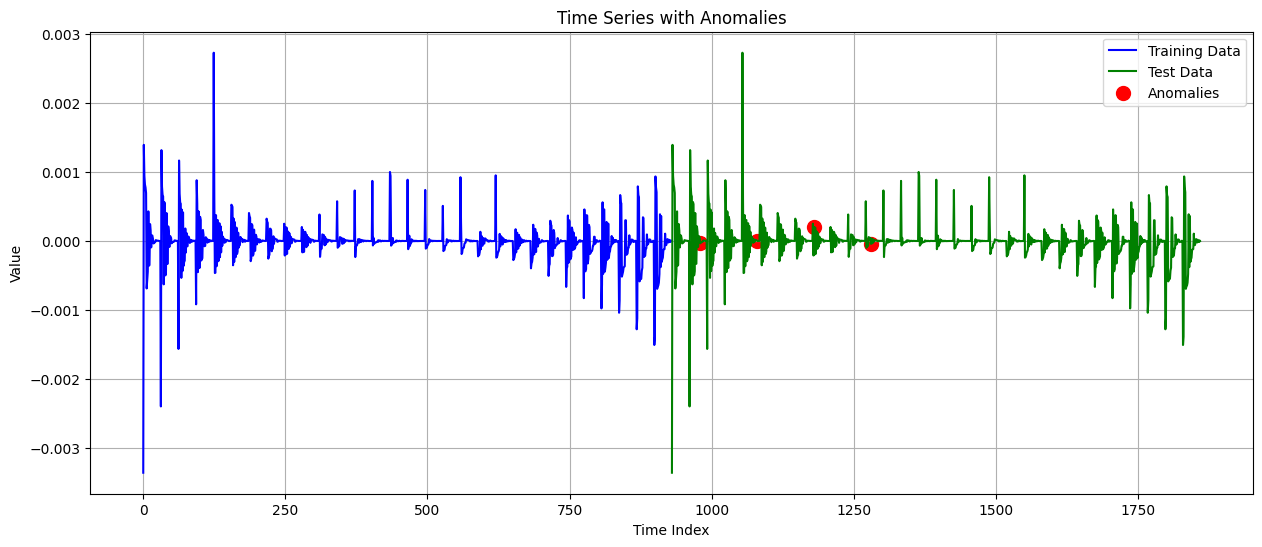

In [85]:
column_start = 45   # Starting position of the second column
column_width = 30  # Width of the second column
import numpy as np 
column_index = 1  # Second column
result_array = []
np.set_printoptions(precision=10, suppress=False) 

with open('list.txt', 'r') as f:
    for line in f:
        columns = line[column_start:column_start + column_width]
        if len(columns) > column_index:
            value = float(columns)
            result_array = np.append(result_array, value)
plot_anomalies(result_array, result_array, labels)      


In [17]:

print("Train data shape:", datasets['dataset1'][0].shape)
print("Test data shape:", datasets['dataset1'][1].shape) 
print("Labels shape:", datasets['dataset1'][2].shape)

Train data shape: (400,)
Test data shape: (600,)
Labels shape: (600,)


In [24]:
# Labels in dataset1  
#datasets['dataset1'][0] 


In [25]:
#datasets['dataset2']


Dataset: dataset1

Algorithm: isolation_forest
accuracy: 0.485
f1: 0.000
precision: 0.000
recall: 0.000
auc: 0.244

Algorithm: one_class_svm
accuracy: 0.333
f1: 0.000
precision: 0.000
recall: 0.000
auc: 0.168

Algorithm: local_outlier_factor
accuracy: 0.339
f1: 0.000
precision: 0.000
recall: 0.000
auc: 0.171


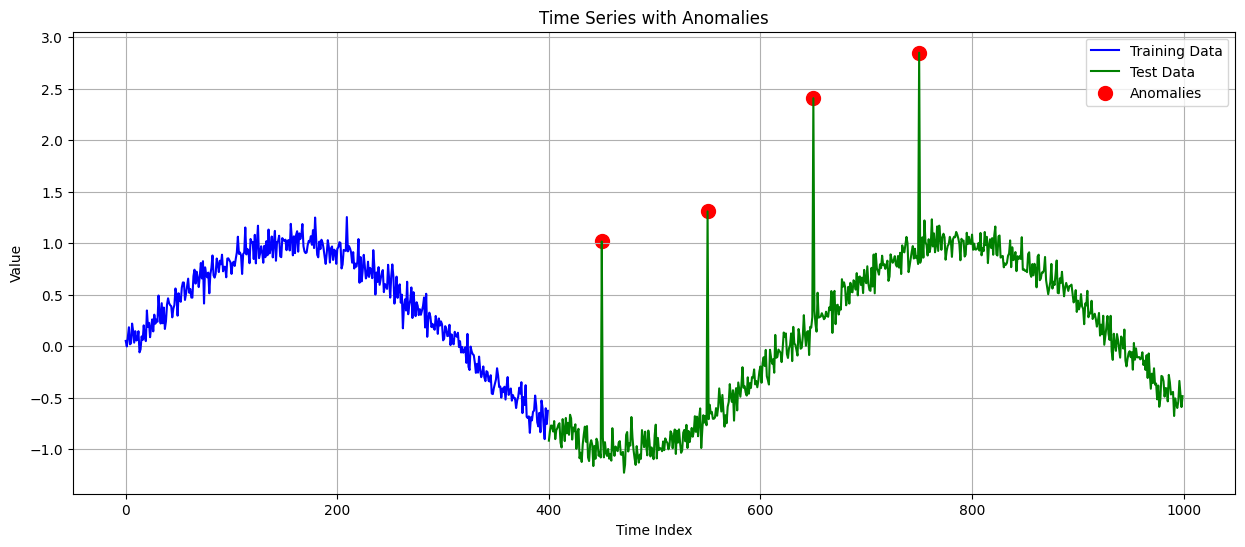


Dataset: dataset2

Algorithm: isolation_forest
accuracy: 0.485
f1: 0.000
precision: 0.000
recall: 0.000
auc: 0.244

Algorithm: one_class_svm
accuracy: 0.333
f1: 0.000
precision: 0.000
recall: 0.000
auc: 0.168

Algorithm: local_outlier_factor
accuracy: 0.339
f1: 0.000
precision: 0.000
recall: 0.000
auc: 0.171


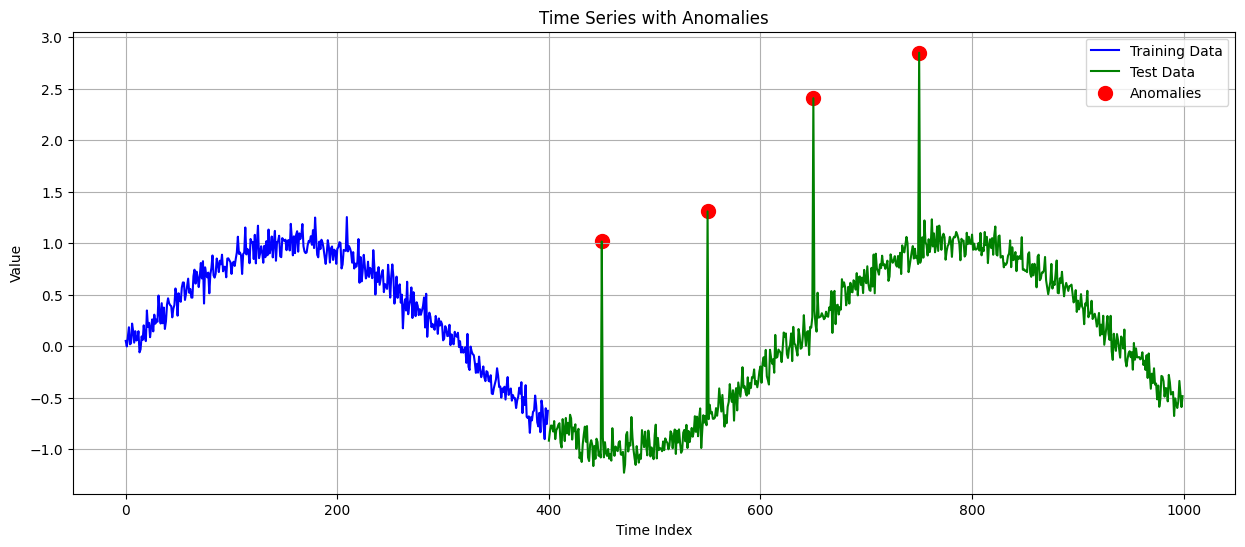

In [23]:

results = evaluate_datasets(datasets)

# Print results
for dataset, algorithms in results.items():
    print(f"\nDataset: {dataset}")
    for algorithm, metrics in algorithms.items():
        print(f"\nAlgorithm: {algorithm}")
        for metric, value in metrics.items():
            print(f"{metric}: {value:.3f}")
        # Generate and plot data
    train_data, test_data, labels = generate_example_data()
    plot_anomalies(train_data, test_data, labels)       